In [36]:
import numpy as np
import pandas as pd
import glob
import sys
import vcf
import csv
import os
from os import listdir
from os import path
import subprocess
import re
import itertools
import matplotlib
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted
from matplotlib import pyplot as plt

In [51]:
def read(f):
    reader = vcf.Reader(open(f))
    df = pd.DataFrame([vars(r) for r in reader])
    out = df.merge(pd.DataFrame(df.INFO.tolist()),
                   left_index=True, right_index=True)
    return out

def compare(x):
    for i in x:
        lis = [combined_vcfs.iloc[i,2],combined_vcfs.iloc[i,5],combined_vcfs.iloc[i,8]]
        lis = ''.join(lis)
        if lis in A:
            combined_vcfs.iloc[i, combined_vcfs.columns.get_loc('Category')] = 'A'
        if lis in B:
            combined_vcfs.iloc[i, combined_vcfs.columns.get_loc('Category')] = 'B'
        if lis in C:
            combined_vcfs.iloc[i, combined_vcfs.columns.get_loc('Category')] = 'C'
        if lis in D:
            combined_vcfs.iloc[i, combined_vcfs.columns.get_loc('Category')] = 'D'
        if lis in E:
            combined_vcfs.iloc[i, combined_vcfs.columns.get_loc('Category')] = 'E'
        if lis in F:
            combined_vcfs.iloc[i, combined_vcfs.columns.get_loc('Category')] = 'F'
        if lis in G:
            combined_vcfs.iloc[i, combined_vcfs.columns.get_loc('Category')] = 'G'
        if lis in H:
            combined_vcfs.iloc[i, combined_vcfs.columns.get_loc('Category')] = 'H'
        if lis in N:
            combined_vcfs.iloc[i, combined_vcfs.columns.get_loc('Category')] = 'N'

            
def vcf_merge(z):
    simulated = read('{s}/{s}_sim.vcf'.format(s=sample))
    genie = read('{s}/{s}_genie.vcf'.format(s=sample))
    vsnp = read('{s}/{s}_filtered_hapall.vcf'.format(s=sample))
    simulated = simulated[['CHROM','POS','REF','ALT']]

#EXTRACT COLUMNS AND SWITCH CHROM NAME TO SAMPLE NAME
    simulated["CHROM"] = simulated["CHROM"].replace('NC_002945.4','{s}_sim'.format(s=sample))
    genie = genie[['CHROM','POS','REF','ALT']]
    genie["CHROM"] = genie["CHROM"].replace('NC_002945.4','{s}_genie'.format(s=sample))
    vsnp = vsnp[['CHROM','POS','REF','ALT']]
    vsnp["CHROM"] = vsnp["CHROM"].replace('NC_002945.4','{s}_vsnp'.format(s=sample))

#REMOVE LIST FROM ALT
    simulated['ALT'] = simulated['ALT'].apply(lambda x: ', '.join(map(str, x)))
    genie['ALT'] = genie['ALT'].apply(lambda x: ', '.join(map(str, x)))
    vsnp['ALT'] = vsnp['ALT'].apply(lambda x: ', '.join(map(str, x)))

#ADD PREFIXES TO COLUMN NAMES
    simulated = simulated.rename(columns = {'REF':'{s}_filt_REF'.format(s=sample),'ALT':'{s}_filt_ALT'.format(s=sample)})
    genie = genie.rename(columns = {'REF':'{s}_filt_REF'.format(s=sample),'ALT':'{s}_filt_ALT'.format(s=sample)})
    vsnp = vsnp.rename(columns = {'REF':'{s}_filt_REF'.format(s=sample),'ALT':'{s}_filt_ALT'.format(s=sample)})

#COMBINE DATAFRAMES BASED ON POSITION
    dataframe = pd.merge(simulated, genie,  how='outer', on=['POS'])
    global combined_vcfs
    combined_vcfs = pd.merge(dataframe, vsnp, how='outer', on=['POS'])
#Add category
    combined_vcfs['Category'] = 'N'
#Change NaN to N
    combined_vcfs = combined_vcfs.fillna('N')
#Change index and save as csv
    combined_vcfs = combined_vcfs.set_index('POS')
    combined_vcfs.to_csv('{s}_combined.csv'.format(s=sample),index=True)
    numbers = list(range(0,combined_vcfs.shape[0]))
    compare(numbers)
            

def gen_comparison(x):
    print(combined_vcfs['Category'].value_counts())
    nums_A = combined_vcfs.loc[combined_vcfs['Category'] == 'A'].shape[0]
    nums_B = combined_vcfs.loc[combined_vcfs['Category'] == 'B'].shape[0]
    nums_C = combined_vcfs.loc[combined_vcfs['Category'] == 'C'].shape[0]
    nums_D = combined_vcfs.loc[combined_vcfs['Category'] == 'D'].shape[0]
    nums_E = combined_vcfs.loc[combined_vcfs['Category'] == 'E'].shape[0]
    nums_F = combined_vcfs.loc[combined_vcfs['Category'] == 'F'].shape[0]
    nums_G = combined_vcfs.loc[combined_vcfs['Category'] == 'G'].shape[0]
    nums_H = combined_vcfs.loc[combined_vcfs['Category'] == 'H'].shape[0]
    nums_N = combined_vcfs.loc[combined_vcfs['Category'] == 'N'].shape[0]
    comparison.iloc[0, comparison.columns.get_loc('count')] = nums_A
    comparison.iloc[1, comparison.columns.get_loc('count')] = nums_B
    comparison.iloc[2, comparison.columns.get_loc('count')] = nums_C
    comparison.iloc[3, comparison.columns.get_loc('count')] = nums_D
    comparison.iloc[4, comparison.columns.get_loc('count')] = nums_E
    comparison.iloc[5, comparison.columns.get_loc('count')] = nums_F
    comparison.iloc[6, comparison.columns.get_loc('count')] = nums_G
    comparison.iloc[7, comparison.columns.get_loc('count')] = nums_N
    comparison.to_csv('{s}_comparison.csv'.format(s=sample),index=True)
    
    v3 = venn3_unweighted(subsets = {'100':nums_F, '010':nums_G, '110':nums_B, 
                                     '001':nums_E, '101':nums_D, '011':nums_C, '111':nums_A},
                          set_labels = ('simulated', 'snp_genie', 'vsnp')),   
    
    matplotlib.pyplot.title("{s}".format(s=sample))
    matplotlib.pyplot.savefig('{s}_venn.png'.format(s=sample))
    
    return comparison

    

In [27]:
#Generate all possible combinations of "ACGT"
li = ['A', 'C', 'G', 'T', 'N']
combs = [''.join(comb) for comb in itertools.product(li, repeat=(len(li)-2))]

#Define combination categories
A = []
for i in (combs):
    if (i[0] == i[1]) & (i[0] == i[2]) & (i[0] != 'N'):
        A.append(i)
B = []
for i in (combs):
    if (i[0] == i[1]) & (i[0] != i[2]) & ((i[0] != 'N') | (i[1] != 'N')) :
        B.append(i)
C = []
for i in (combs):
    if (i[1] == i[2]) & (i[0] != i[1]) & ((i[1] != 'N') & (i[2] != 'N')):
        C.append(i)       
D = []
for i in (combs):
    if (i[0] == i[2]) & (i[0] != i[1]) & ((i[0] != 'N') & (i[2] != 'N')):
        D.append(i)
#Only in vsnp
E = []
for i in (combs):
    if (i[0] == i[1]) & (i[0] != i[2]) & ((i[0] == 'N') | (i[1] == 'N')) :
        E.append(i)
#Only in sim        
F = []
for i in (combs):
    if ((i[1] == i[2]) & (i[0] != i[1])) & (i[1] == 'N'):
        F.append(i)
#Only snp_genie
G = []
for i in (combs):
    if (i[0] == i[2]) & (i[0] != i[1]) & ((i[0] == 'N') & (i[2] == 'N')):
        G.append(i)
#All different
H = []
for i in (combs):
    if (i[0] != i[1]) & (i[1] != i[2]) & (i[0] != i[2]):
        H.append(i)
#N (possible errors)
N = []
for i in (combs):
    if (i[0] == 'N') & (i[1] == 'N') & (i[2] == 'N'):
        N.append(i)

A    330
D      8
F      7
Name: Category, dtype: int64


,Category,13-11594_sim,13-11594_genie,13-11594_vsnp,count
A,All,1,1,1,330
B,sim+genie,1,1,0,0
C,genie+vsnp,0,1,1,0
D,sim+vsnp,1,0,1,8
E,vsnp_only,0,0,1,0
F,sim_only,1,0,0,7
G,genie_only,0,1,0,0
N,Error?,N,N,N,0


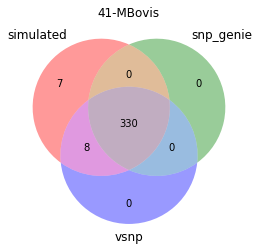

In [53]:
gen_comparison(directories[0])

In [28]:
#GENERATE DATAFRAME FOR VENN DIAGRAM
comparison = pd.DataFrame(columns = ["Category","13-11594_sim","13-11594_genie","13-11594_vsnp","count"],
                         data = [("All",1,1,1,'Empty'), ("sim+genie",1,1,0,'Empty'), ("genie+vsnp",0,1,1,'Empty'), ("sim+vsnp",1,0,1,'Empty'),
                                ("vsnp_only",0,0,1,'Empty'), ("sim_only",1,0,0,'Empty'), ("genie_only",0,1,0,'Empty'),("Error?",'N','N','N','Empty')],
                         index= ['A','B','C','D','E','F','G','N'])

In [29]:
import glob

#print (glob.glob('*'))

?glob.glob

59-6110
File count:0
A    342
D      8
F      3
Name: Category, dtype: int64
55-4348
File count:1
A    339
D      8
F      6
Name: Category, dtype: int64
48-MBovis
File count:2
A    339
D     10
F      7
Name: Category, dtype: int64
13-11594
File count:3
A    332
D     10
F      2
Name: Category, dtype: int64
44-MBovis
File count:4
A    334
F      8
D      8
E      1
Name: Category, dtype: int64
54-MBovis
File count:5
A    339
F      9
D      8
Name: Category, dtype: int64
52-3698
File count:6
A    336
D     11
F      1
Name: Category, dtype: int64
3-10110
File count:7
A    340
D      5
F      3
Name: Category, dtype: int64
56-MBovis
File count:8
A    333
D     10
F      4
Name: Category, dtype: int64
47-MBovis
File count:9
A    335
D     10
F      8
Name: Category, dtype: int64
26-12883
File count:10
A    337
D     10
F      3
Name: Category, dtype: int64
48-2919
File count:11
A    335
D      7
F      3
Name: Category, dtype: int64
28-12935
File count:12
A    343
D      8
F      5
Nam

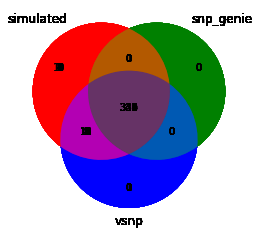

In [30]:
pd.options.display.max_rows = 999
directories = list(filter(os.path.isdir, os.listdir()))
directories.remove('.ipynb_checkpoints')
directories[0]
file_count = 0
length = len(directories)
while file_count < length:
    if file_count == length :
        pass
        file_count +=1
    else:
        sample = directories[file_count]
        print(sample)
        print('File count:{s}'.format(s=file_count))
        vcf_merge(directories)
        gen_comparison(directories)
        file_count = file_count + 1

In [54]:
gen_comparison(directories)

A    342
D      8
F      3
Name: Category, dtype: int64


NameError: name 'sample' is not defined

,Category,13-11594_sim,13-11594_genie,13-11594_vsnp,count
A,All,1,1,1,342
B,sim+genie,1,1,0,0
C,genie+vsnp,0,1,1,0
D,sim+vsnp,1,0,1,8
E,vsnp_only,0,0,1,0
F,sim_only,1,0,0,3
G,genie_only,0,1,0,0
N,Error?,N,N,N,0


In [296]:
v3 = venn3_unweighted(subsets = {'100':nums_F, '010':nums_G, '110':nums_B,
                      '001':nums_E, '101':nums_D, '011':nums_C, '111':nums_A},
           set_labels = ('simulated', 'snp_genie', 'vsnp'))

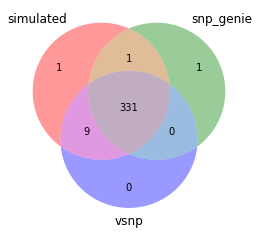